# Anomly Detection in JP Morgan Synthetic Fraud Dataset with TODS

## Introduction Summary

## What is TODS?

TODS, developed by DATA Lab @ Texas A&M University, is a full-stack automated machine learning system for outlier detection on multivariate time-series data. TODS provides exhaustive modules for building machine learning-based outlier detection systems, including: data processing, time series processing, feature analysis (extraction), detection algorithms, and reinforcement module.

## What is JP Morgan Synthetic Fraud Dataset?

Data representing transactions from a subject-centric view with the goal of identifying fraudulent transaction. This data contains a large variety of transaction types representing normal activities as well as abnormal/fraudulent activities that are introduced with predefined probabilities. The data was generated by running an AI planning-execution simulator and translating the output planning traces into tabular format.

More information can be found at https://www.jpmorgan.com/technology/artificial-intelligence/initiatives/synthetic-data/payments-data-for-fraud-detection

## How does TODS detect anomalies from JP Morgan dataset?

With TODS, we first collect and process the data to put in a dataframe. Next, we use one primitive from TODS to fit and predict on all dimensions of the data, to get the prediction labels and scores.

The searcher of TODS will take the dataset and automatically build a pipeline to find the best possible model with its scores.


# Data pre-processing

## Data Loading

In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("JPMAIR_synthetic-data-Payment-Fraud-1000-100.csv")
print(data.shape)

(82846, 13)


#### Creating Dataframe

In [6]:
df = pd.DataFrame(data)

#### Divide columns into multiple columns

In [7]:
# Divide Sender_Id into 2 columns
df['Sender_Type'] = df['Sender_Id']

df['Sender_Type'] = df['Sender_Type'].str.replace('\d+', '')
df['Sender_Type'] = df['Sender_Type'].str.replace('-', '')

pd.get_dummies(df.Sender_Type)
ST_Count_dummies = pd.get_dummies(df.Sender_Type)
df = pd.concat([df, ST_Count_dummies], axis = 1)

df.drop(["Sender_Type"], axis = 1, inplace = True)
df['Sender_Id'] = df['Sender_Id'].str.extract('(\d+)', expand=False)

In [8]:
# Divide Bene_Id into 2 columns
df['Bene_Type'] = df['Bene_Id']

df['Bene_Type'] = df['Bene_Type'].str.replace('\d+', '')
df['Bene_Type'] = df['Bene_Type'].str.replace('-', '')
#print(df.head())

pd.get_dummies(df.Bene_Type)
BT_Count_dummies = pd.get_dummies(df.Bene_Type)
df = pd.concat([df, BT_Count_dummies], axis = 1)

df.drop(["Bene_Type"], axis = 1, inplace = True)
df['Bene_Id'] = df['Bene_Id'].str.extract('(\d+)', expand=False)

#data['Label'].value_counts()

## Pie Plot

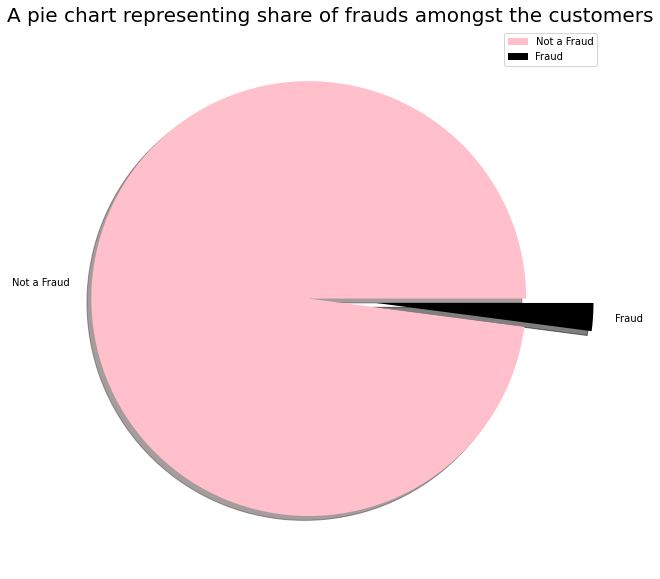

In [9]:
# Diagrammatic representation of Label column 
labels = ['Not a Fraud', 'Fraud']
colors = ['pink', 'black']
size = [81131, 1715]
explode = [0.1, 0.21]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True)
plt.axis('off')
plt.title('A pie chart representing share of frauds amongst the customers',fontsize = 20)
plt.legend()
plt.show()

#### Drop Missing Values

In [10]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#### One Hot-Encoding columns

In [11]:
# One Hot-Encoding Sender Country column
pd.get_dummies(df.Sender_Country)
S_Count_dummies = pd.get_dummies(df.Sender_Country)
df = pd.concat([df, S_Count_dummies], axis = 1)

In [12]:
# One Hot-Encoding Bene_Country
B_Count_dummies = pd.get_dummies(df.Bene_Country)
df = pd.concat([df, B_Count_dummies], axis = 1)

In [13]:
# One Hot-Encoding Transaction Type
Trans_type = pd.get_dummies(df.Transaction_Type)
df = pd.concat([df, Trans_type], axis = 1)

#### Check for Unique Values in Sender_Iob

In [14]:
print(df.Sender_lob.value_counts())

CCB    58344
Name: Sender_lob, dtype: int64


#### Delete columns

In [15]:
df.drop(["Sender_lob"], axis = 1, inplace = True)

del df['Sender_Country']
del df['Bene_Country']
del df['Transaction_Type']

#### Removed Redundant string part from columns

In [16]:
df['Transaction_Id'] = df['Transaction_Id'].str.extract('(\d+)', expand=False)
df['Sender_Account'] = df['Sender_Account'].str.extract('(\d+)', expand=False)

In [17]:
df['Bene_Account'] = df['Bene_Account'].str.extract('(\d+)',expand=False)

### Saving data after pre-processing

In [18]:
df.to_csv('data3.csv', index=False)

## Search example

In [19]:
from d3m import index
from d3m.metadata.base import ArgumentType
from d3m.metadata.pipeline import Pipeline, PrimitiveStep
from axolotl.backend.simple import SimpleRunner
from tods import generate_dataset, generate_problem
from tods.searcher import BruteForceSearch
from tods import generate_dataset, load_pipeline, evaluate_pipeline
import pandas as pd

table_path = 'data-2.csv'
target_index = 7 # what column is the target
time_limit = 50 # How many seconds you wanna search
metric = 'F1_MACRO' # F1 on both label 0 and 1

# Read data and generate dataset and problem
df = pd.read_csv(table_path)
df.drop(["Time_step"], axis = 1, inplace = True)
dataset = generate_dataset(df, target_index=target_index)
problem_description = generate_problem(dataset, metric)

# Start backend
backend = SimpleRunner(random_seed=0)
# Start search algorithm
search = BruteForceSearch(problem_description=problem_description,backend=backend)
# Find the best pipeline
best_runtime, best_pipeline_result = search.search_fit(input_data=[dataset], time_limit=time_limit)
# print(best_runtime)
best_pipeline = best_runtime.pipeline
best_output = best_pipeline_result.output
# Evaluate the best pipeline
best_scores = search.evaluate(best_pipeline).scores
print('Search History:')
for pipeline_result in search.history:
    print('-' * 52)
    print('Pipeline id:', pipeline_result.pipeline.id)
    print(pipeline_result.scores)
    
print('Best pipeline:')
print('-' * 52)
print('Pipeline id:', best_pipeline.id)
print('Pipeline json:', best_pipeline.to_json())
print('Output:')
print(best_output)
print('Scores:')
print(best_scores)

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1032)              1066056   
_________________________________________________________________
dropout (Dropout)            (None, 1032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1032)              1066056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1033      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8

/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
Traceback (most recent call last):
  File "/Users/macbook/tods_1/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1032)              1066056   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1032)              1066056   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1033      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1032)              1066056   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1032)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1032)              1066056   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1032)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1033      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Search History:
----------------------------------------------------
Pipeline id: ba57a250-fac3-440f-ace3-098a69fa76b5
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.496874    0.496874           0     0
Best pipeline:
----------------------------------------------------
Pipeline id: ba57a250-fac3-440f-ace3-098a69fa76b5
Pipeline json: {"id": "ba57a250-fac3-440f-ace3-098a69fa76b5", "schema": "https://metadata.datadrivendiscovery.org/schemas/v0/pipeline.json", "created": "2021-08-11T18:18:18.732674Z", "inputs": [{"name": "inputs"}], "outputs": [{"data": "steps.7.produce", "name": "output predictions"}], "steps": [{"type": "PRIMITIVE", "primitive": {"id": "c78138d9-9377-31dc-aee8-83d9df049c60", "version": "0.3.0", "python_path": "d3m.primitives.tods.data_processing.dataset_to_dataframe", "name": "Extract a DataFrame from a Dataset"}, "arguments": {"inputs": {"type": "CONTAINER", "data": "inputs.0"}}, "outputs": [{"id": "produce"}]}, {"type": "PRIMITIVE", "primitive": {"

## Implementing Isolation Forest Example

In [21]:
import numpy as np
from tods.sk_interface.detection_algorithm.IsolationForest_skinterface import IsolationForestSKI
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd


#prepare the data
data = pd.read_csv('data-2.csv')#, header = None)
data = data.drop(columns=['Label'])
data1 = pd.read_csv('data-2.csv')
df = data1['Label']


to_model_columns = data.columns[1:]
data = data[to_model_columns]
X_train = np.expand_dims(data[:50000], axis=1)
X_train = np.squeeze(X_train)
X_test = np.expand_dims(data[50000:], axis=1)
X_test = np.squeeze(X_test)
y_true = np.expand_dims(df[50000:], axis=1)
y_true = np.squeeze(y_true)


transformer = IsolationForestSKI(contamination=0.1)
transformer.fit(X_train)
prediction_labels_train = transformer.predict(X_train)
prediction_labels = transformer.predict(X_test)
prediction_score = transformer.predict_score(X_test)


print("Prediction Labels\n", prediction_labels)
print("Prediction Score\n", prediction_score)


y_pred = prediction_labels


print('Accuracy Score: ', accuracy_score(y_true, y_pred))


confusion_matrix(y_true, y_pred)


print(classification_report(y_true, y_pred))

/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/macbook/qenv/myvenv/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Prediction Labels
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
Prediction Score
 [[-0.01646472]
 [-0.01603142]
 [-0.01334226]
 ...
 [-0.01054124]
 [-0.01355491]
 [ 0.03587787]]
Accuracy Score:  0.837967401725791
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8154
           1       0.02      0.12      0.03       190

    accuracy                           0.84      8344
   macro avg       0.50      0.49      0.47      8344
weighted avg       0.95      0.84      0.89      8344

